In [6]:
# !pip install wordcloud
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [7]:
def back_to_list(s):
    end = s.replace('[', '').replace(']', '').replace('\'', '').replace(' ', '').split(',')
    return end

data = pd.read_csv("../../data/reuters_train.csv")
data.body = data.body.apply(lambda x: back_to_list(x))
data.title = data.title.apply(lambda x: back_to_list(x))
data.head()

,body,title
0,"[sapporo, breweries, ltd, of, japan, is, issui...","[sapporo, breweries, issues, five, year, sfr, ..."
1,"[zenith, laboratories, inc, said, the, company...","[zenith, labs, zen, will, report, 4th, qtr, loss]"
2,"[usx, corp, said, its, uss, division, and, inl...","[usx, x, inland, iad, in, steel, coil, venture]"
3,"[dst, systems, inc, said, its, president, and,...","[dst, systems, dsts, president, dies]"
4,"[iraq, said, today, its, troops, had, killed, ...","[iraq, says, iran, offensive, on, southern, fr..."


In [8]:
data['bodyLength'] = [len(x) for x in data.body]
data['titleLength'] = [len(x) for x in data.title]

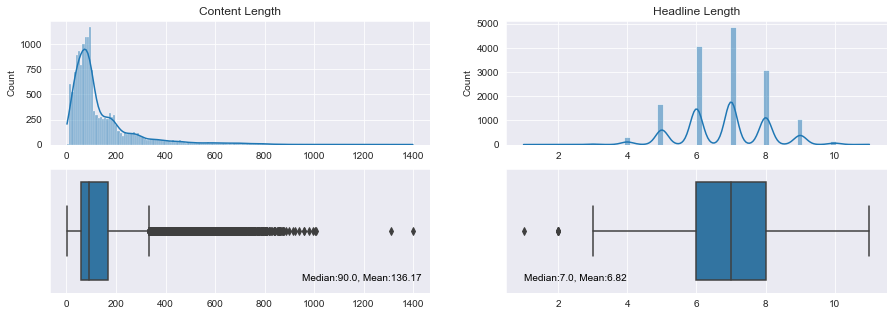

In [14]:
f = plt.figure(figsize=(15, 5))
gs = f.add_gridspec(2, 2)

# histogram
ax = f.add_subplot(gs[0, 0])
bodyhist = sns.histplot(data.bodyLength, kde=True)
bodyhist.set(xlabel=None)
plt.title("Content Length", fontsize=12)
ax = f.add_subplot(gs[0, 1])
titlehist = sns.histplot(data.titleLength, kde=True)
titlehist.set(xlabel=None)
plt.title("Headline Length", fontsize=12)

# boxplots
ax = f.add_subplot(gs[1, 0])
bodybox = sns.boxplot(data=data, x='bodyLength', orient='h')
bmedian, bmean = round(np.median(data.bodyLength), 2), round(np.mean(data.bodyLength), 2)
bodybox.text(950, 0.4, f'Median:{str(bmedian)}, Mean:{str(bmean)}', horizontalalignment='left', color='black')
bodybox.set(xlabel=None)

ax = f.add_subplot(gs[1, 1])
titlebox = sns.boxplot(data=data, x='titleLength', orient='h')
tmedian, tmean = round(np.median(data.titleLength), 2), round(np.mean(data.titleLength), 2)
titlebox.text(1, 0.4, f'Median:{str(tmedian)}, Mean:{str(tmean)}', horizontalalignment='left', color='black')
titlebox.set(xlabel=None)

plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sujeong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


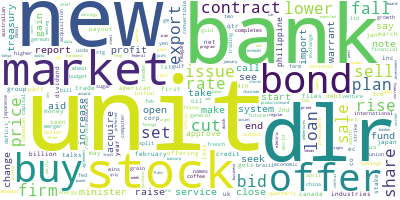

In [10]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['reuters', 'reuter', 'said', 'pct', 'mln', 'billions', 'n'])

full = []
for row in data.title:
    full += row
no_stopwords = [word for word in full if word not in stop_words]
freq_words = [x for x,y in Counter(no_stopwords).most_common(500)]
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3)
wordcloud.generate_from_text(' '.join(freq_words))
wordcloud.to_image()

## Below is LDA but hard to draw insightful conclusions..

In [11]:
# !pip install gensim
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
titles = data.title.values.tolist()
title_words = list(sent_to_words(titles))
# remove stop words
title_words = remove_stopwords(title_words)

C:\Users\sujeong\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [12]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(title_words)
# Create Corpus
texts = title_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in title_words]

In [13]:
from pprint import pprint
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.016*"us" + 0.011*"says" + 0.010*"inc" + 0.009*"qtr" + 0.009*"bank" + '
  '0.007*"corp" + 0.007*"unit" + 0.006*"debt" + 0.005*"offer" + 0.005*"net"'),
 (1,
  '0.015*"net" + 0.013*"qtr" + 0.012*"sees" + 0.010*"us" + 0.009*"new" + '
  '0.008*"corp" + 0.006*"unit" + 0.006*"oil" + 0.005*"stake" + 0.005*"year"'),
 (2,
  '0.020*"qtr" + 0.017*"net" + 0.015*"us" + 0.011*"inc" + 0.010*"unit" + '
  '0.009*"japan" + 0.009*"uk" + 0.008*"corp" + 0.007*"st" + 0.006*"money"'),
 (3,
  '0.008*"sales" + 0.006*"dlr" + 0.006*"debt" + 0.006*"us" + 0.006*"stock" + '
  '0.005*"buy" + 0.005*"sells" + 0.005*"loss" + 0.005*"bank" + 0.004*"new"'),
 (4,
  '0.026*"qtr" + 0.023*"net" + 0.022*"inc" + 0.014*"corp" + 0.012*"sets" + '
  '0.010*"rd" + 0.008*"th" + 0.006*"year" + 0.006*"loss" + 0.005*"says"')]
